# Predição de Comprometimento Cognitivo com Base em Dados de Pacientes
Este notebook cria um modelo otimizado para prever o comprometimento cognitivo em quatro classes.

In [47]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib

# Configurações gerais
%matplotlib inline
sns.set(style='whitegrid')

In [48]:
# 1. Carregar o Dataset
df = pd.read_csv('D:\\Projetos\\TrabalhoFinalDataScience\\AlzheimerEarlyDetection\\alzheimers_disease_data.csv')
print('Primeiras linhas do dataset:')
print(df.head())
print('\nInformações do dataset:')
print(df.info())
print('\nValores ausentes por coluna:')
print(df.isnull().sum())

Primeiras linhas do dataset:
   PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       4751   73       0          0               2  22.927749        0   
1       4752   89       0          0               0  26.827681        0   
2       4753   73       0          3               1  17.795882        0   
3       4754   74       1          0               1  33.800817        1   
4       4755   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  MemoryComplaints  \
0           13.297218          6.327112     1.347214  ...                 0   
1            4.542524          7.619885     0.518767  ...                 0   
2           19.555085          7.844988     1.826335  ...                 0   
3           12.209266          8.428001     7.435604  ...                 0   
4           18.454356          6.310461     0.795498  ...                 0   

   BehavioralProblems       ADL  Confus

Distribuição da variável target:
target
Moderate Impairment     1499
Mild Impairment          301
No Impairment            197
Very Mild Impairment     152
Name: count, dtype: int64


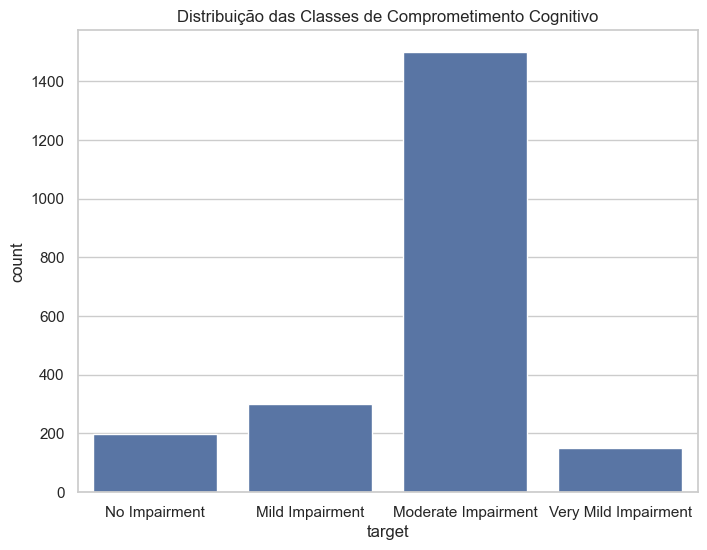

In [49]:
# 2. Criar a Coluna Target com Base no MMSE
def classify_mmse(mmse):
    if mmse >= 27:
        return 0  # No Impairment
    elif 24 <= mmse <= 26:
        return 3  # Very Mild Impairment
    elif 19 <= mmse <= 23:
        return 1  # Mild Impairment
    else:
        return 2  # Moderate Impairment

df['target'] = df['MMSE'].apply(classify_mmse)
class_names = {0: 'No Impairment', 1: 'Mild Impairment', 2: 'Moderate Impairment', 3: 'Very Mild Impairment'}
print('Distribuição da variável target:')
print(df['target'].value_counts().rename(index=class_names))
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.xticks(ticks=[0, 1, 2, 3], labels=class_names.values())
plt.title('Distribuição das Classes de Comprometimento Cognitivo')
plt.show()

In [50]:
# 3. Pré-processamento dos Dados
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

le = LabelEncoder()
categorical_cols = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers',
                    'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
                    'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation',
                    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df = df.drop(['PatientID', 'DoctorInCharge', 'Diagnosis', 'MMSE'], axis=1)
X = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_11052\2361145467.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_11052\2361145467.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [51]:
# 4. Tratamento de Classes Desbalanceadas (SMOTE)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print('Distribuição após SMOTE:')
print(pd.Series(y_train_bal).value_counts().rename(index=class_names))

Distribuição após SMOTE:
target
Mild Impairment         1199
Moderate Impairment     1199
Very Mild Impairment    1199
No Impairment           1199
Name: count, dtype: int64


In [52]:
# 5. Treinamento do Modelo com Otimização
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_bal, y_train_bal)
model = grid_search.best_estimator_
print('Melhores parâmetros:', grid_search.best_params_)

# Previsões
y_pred = model.predict(X_test)

Melhores parâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


Relatório de Classificação:
                      precision    recall  f1-score   support

       No Impairment       0.00      0.00      0.00        40
     Mild Impairment       0.00      0.00      0.00        60
 Moderate Impairment       0.70      0.97      0.81       300
Very Mild Impairment       0.00      0.00      0.00        30

            accuracy                           0.68       430
           macro avg       0.17      0.24      0.20       430
        weighted avg       0.49      0.68      0.57       430



c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

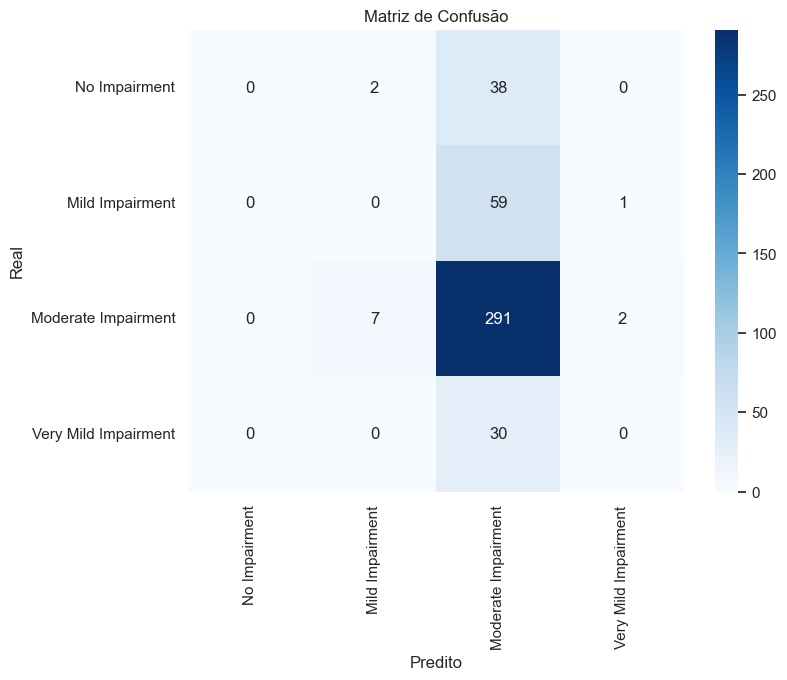

In [53]:
# 6. Avaliação do Modelo
print('Relatório de Classificação:')
print(classification_report(y_test, y_pred, target_names=class_names.values()))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

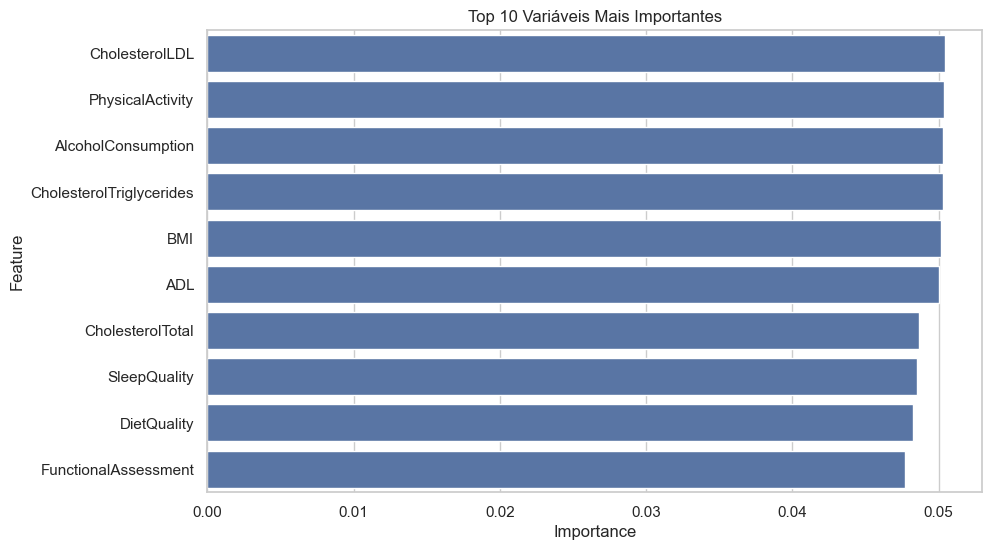

In [54]:
# 7. Interpretação do Modelo
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Variáveis Mais Importantes')
plt.show()

In [ ]:
# 8. Exportação do Modelo e Exibição da Acurácia
joblib.dump(model, 'alzheimer_csv_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('Modelo e scaler salvos com sucesso!')

accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.2f} ({accuracy * 100:.2f}%)')

# Validação cruzada para estimativa mais robusta
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f'Acurácia média com validação cruzada: {cv_scores.mean():.2f} (± {cv_scores.std():.2f})')

Modelo e scaler salvos com sucesso!
Acurácia do modelo: 0.68 (67.67%)
Acurácia média com validação cruzada: 0.70 (± 0.00)
